![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict

In [4]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [5]:
bikes.shape #tenemos 12 variables y 10886 registros

(10886, 12)

### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [27]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [28]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [29]:
# Tipos de datos de la base
bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  total       10886 non-null  int64  
 11  hour        10886 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.1 MB


Se identifican las 12 variables del estudio, encontrando que no hay valores perdidos. Para el ejercicio nos vamos a enfocar solamente en las variables "hora" y "season". 

**HORA:** representa la hora del día en la que se prestan las bicicletas. En este caso se infiere que el servicio se presta las 24 horas del día

De la hora, se puede decir hasta ahora que se presentan dos picos de uso: cerca de las 7 de la mañana, cuando la gente probablemente vaya a trabajar, y otro entre las 5 y 6 de la tarde, finalizando la jornada. 

**SEASON:** temporada. Nos indica la temporada o estación del año, siendo 1 invierno, 2 primavera, 3 verano y 4 otoño.

Por temporada, se nota que para el invierno se dan los niveles más bajos de uso de las bicicletas, probablemente por el mal tiempo. El mayor uso se da entre la primavera y el verano.

Vamos a mirar algunas métricas adicionales de estas dos variables: 

In [36]:
# Estadísticas Descriptivas
df[["hour", "season"]].describe().applymap(lambda x: f"{x:0.3f}")

,hour,season
count,10886.000,10886.000
mean,11.542,2.507
std,6.916,1.116
min,0.000,1.000
25%,6.000,2.000
50%,12.000,3.000
75%,18.000,4.000
max,23.000,4.000


Con lo anterior básicamente corroboramos que efectivamente hay uso de bicicletas las 24 horas del día y que son cuatro estaciones. 

Matriz de correlación


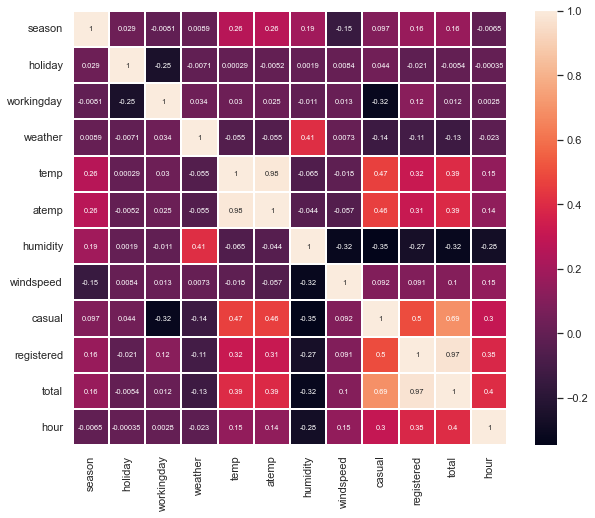

In [37]:
#Matriz de correlación
print('Matriz de correlación')
corr = bikes.corr(method='pearson')
sns.set(rc = {'figure.figsize':(10,8)}) # Ajustar tamaño del grafico.
sns.heatmap(corr, annot = True, annot_kws = {'size': 7.5}, square = True, linewidths = 0.1, linecolor = "white")
plt.show()

En el correlograma se notan algunas correlaciones importantes para algunas variables, como la temperatura y la sensación térmica. Sin embargo, no se haya una correlación entre la hora y la temporada, que son la variables de interés para el ejercicio. 

#### Frecuencias de las variables de interés

<AxesSubplot:title={'center':'Uso de bicicletas por hora y estación del año'}, xlabel='hour', ylabel='total'>

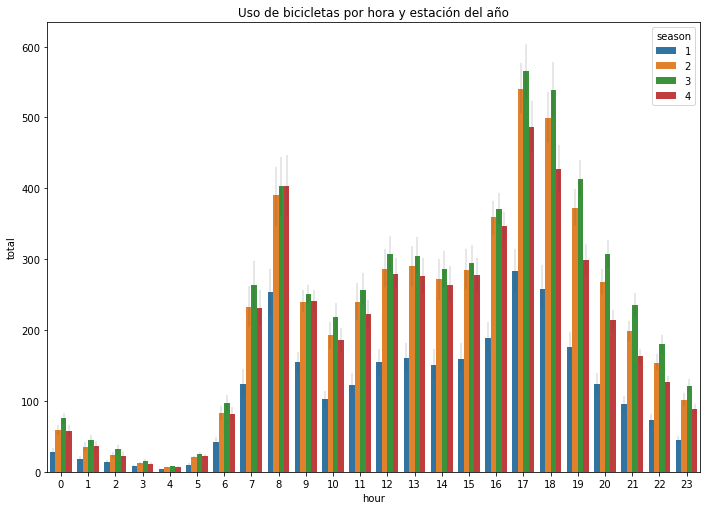

In [66]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
plt.title("Uso de bicicletas por hora y estación del año")
sns.barplot(data=bikes, x='hour', y='total',  hue='season',errwidth=0.25 )


En el gráfico anterior se puede ver además que en todas las horas, el mayor uso de las bicicletas se presenta durante el verano (#3, barra verde). Mientras que en invierno se presentan los resultados más bajos

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:title={'center':'Cantidad de bicicletas usadas por hora'}, xlabel='hour'>

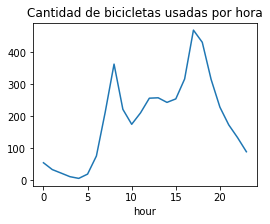

In [68]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
plt.figure(figsize=(4,3))
plt.title("Cantidad de bicicletas usadas por hora")
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:title={'center':'Cantidad de bicicletas usadas por hora en invierno'}, xlabel='hour'>

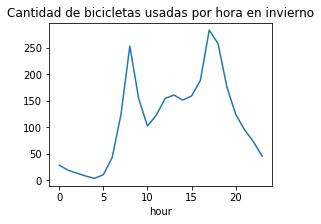

In [70]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bike_invierno = bikes[bikes["season"]==1]

plt.figure(figsize=(4,3))
plt.title("Cantidad de bicicletas usadas por hora en invierno")
bike_invierno.groupby('hour').total.mean().plot()

<AxesSubplot:title={'center':'Cantidad de bicicletas usadas por hora en verano'}, xlabel='hour'>

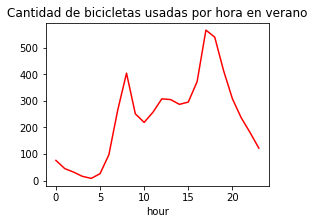

In [73]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bike_verano = bikes[bikes["season"]==3]
plt.figure(figsize=(4,3))
plt.title("Cantidad de bicicletas usadas por hora en verano")
bike_verano.groupby('hour').total.mean().plot(color="red")

#### Análisis punto 2:
Las dos gráficas presentan un comportamiento muy similar, con picos al inicio de la mañana y al final de la tarde. En el invierno ambos picos tienen un valor similar, mientras que en verano el pico del final de la tarde es un poco más pronunciado. 

La gran diferencia tiene que ver con la cantidad promedio de bicicletas usadas, dado que en verano son en general el doble de las usadas en inivierno. 

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [75]:
# Celda 3

#se genera el set de datos solo con las dos variables predictoras solicitadas, y la variable "y" de respuesta con el total
df = bikes[["season", "hour"]]
y = bikes["total"]

In [76]:
#para emplear el modelo de regresión lineal, se debe convertir la variable "season", que es categórica, a sus dummies
X = pd.get_dummies(df, columns=['season'])
X.head()

,hour,season_1,season_2,season_3,season_4
datetime,,,,,
2011-01-01 00:00:00,0,1,0,0,0
2011-01-01 01:00:00,1,1,0,0,0
2011-01-01 02:00:00,2,1,0,0,0
2011-01-01 03:00:00,3,1,0,0,0
2011-01-01 04:00:00,4,1,0,0,0


In [77]:
#se realiza la partición de la muestra en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#se entrena el modelo
linear_mod = LinearRegression()
linear_mod.fit(X_train, y_train)

LinearRegression()

In [79]:
#se calcula el intercepto
print("intercepto: ", linear_mod.intercept_)

#se calculan los coeficientes de cada variable
coeff_parameter = pd.DataFrame(linear_mod.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

intercepto:  67.7662174594875


,Coefficient
hour,10.612507
season_1,-76.067075
season_2,23.589486
season_3,43.242143
season_4,9.235446


In [81]:
#se calcula el MSE del modelo de regresión lineal
predicciones_lineal=modelo_lineal.predict(X_test)
MSE_linear=metrics.mean_squared_error(y_test, predicciones_lineal) 
print('MSE regresión lineal:')
print(MSE_linear)

MSE regresión lineal:
25333.687249926534


#### Análisis punto 3:
Se aplica la regresión lineal a los datos. 

Se presenta la siguiente fórmula del modelo: 

Y = 67.766 + 10.61(hour) - 76.07(invierno) + 23.59(primavera) + 43.24(verano) + 9.23(otoño)

Esto nos indica que por cada aumento de la hora, teniendo las demás variables constantes, se presenta un aumento del total de bicicletas de 10.61 unidades. 

De igual manera se ve que el coeficiente para invierno es negativo, indicando que durante esta estación, el total de bicicletas predicho disminuye hasta 76 unidades. Mientras que en las demás estaciones incrementa, siendo el valor más bajo para el otoño y el más alto para verano. 

Lo anterior es consistente con lo analizado en los puntos de análisis exploratorio previos. 

El MSE calculado para este modelo es de 25333.687

Este modelo presenta una interesante interpretabilidad, dado que vemos los coeficientes de cada variable. Sin embargo, con mayor cantidad de variables se puede comenzar a complicar. Además, es un modelo que tiende a verse afectado por valores extremos y depende de asumir que hay una relación lineal entre las variables dependientes y la de desenlace.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [21]:
# Celda 4

# Definición de parámetros y criterios de parada
max_depth = 6
num_pct = 10
# max_features = None
# min_gain=0.001

In [22]:
# Impresión variable a usar (hour)
j = 0
print(X.columns[j])

hour


In [23]:
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

array([ 0.,  2.,  4.,  7.,  9., 12., 14., 16., 19., 21.])

In [24]:
# División de las observaciones usando el punto de corte en la posición 5 de la lista de splits
k=5
filter_l = X.iloc[:, j] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [25]:
y_r.mean()

264.0239400584795

In [26]:
y_l.mean()

118.34817140746213

In [ ]:
#estuve ensayando con MSE pero finalmente no me funcionó

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [87]:
# Celda 5
#se realiza de nuevo el split de la base
X_train2, X_test2, y_train2, y_test2 = train_test_split(df, y, test_size=0.3, random_state=0)

In [88]:
#entrenamiento del modelo con algunos parámetros
dtr = DecisionTreeRegressor()

param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 4, 6, 8, 10],
              "min_samples_leaf": [20, 50, 100],
              "max_leaf_nodes": [5, 10, 20, 100],
              }

dtr = GridSearchCV(dtr, param_grid, cv=5)

dtr.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_leaf_nodes': [5, 10, 20, 100],
                         'min_samples_leaf': [20, 50, 100],
                         'min_samples_split': [10, 20, 40]})

In [91]:
#verificamos los mejores parámetros
dtr.best_params_

{'criterion': 'mse',
 'max_depth': 8,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 50,
 'min_samples_split': 10}

In [93]:
#se realizan las predicciones
predicciones_dtr=dtr.predict(X_test2)

#cálculo del MSE
MSE_dtr=metrics.mean_squared_error(y_test2, predicciones_dtr) 
print('MSE árbol regresión:')
print(MSE_dtr)

MSE árbol regresión:
13275.45349461614


#### Análisis punto 5:
Se aplica un árbol de regresión los datos (siendo los mismos de la regresión lineal anteriormente ejecutada). 

El MSE calculado para este modelo con calibración de algunos parámetros es de 13275.453, inferior al 25333.687 de la regresión lineal. Esto nos indica que el árbol de regresión tuvo mucho mejor desempeño que la regresión lineal. 

Como ventaja adicional, este modelo no necesitó calcular las dummies para las variables categóricas.


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [95]:
# Lectura de la información de archivo .csv
df_B = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df_B.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [96]:
# Definición variable de interes y variables predictoras
X = df_B.drop(['url', 'Popular'], axis=1) #se elimina la URL y la variable de respuesta
y = df_B['Popular']

In [97]:
# División de la muestra en set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [100]:
# Celda 6

# Estimación del Modelo - árbol de clasificación
dtc = DecisionTreeClassifier()

param_grid = {"criterion": ["entropy", "gini"],
              "max_depth": [2, 4, 10],
              "random_state": [0],
              "min_samples_split": [2, 6, 10, 50],
              }

dtc = GridSearchCV(dtc, param_grid, cv=5)


dtc.fit(X_train, y_train)

# Cálculo de las predicciones en la muestra de evaluación
predicciondtc = dtc.predict(X_test)

# Cálculo de métricas 
dtc_accuracy = metrics.accuracy_score(y_test, predicciondtc)
dtc_f1 = metrics.f1_score(y_test, predicciondtc)

print('Accuracy árbol de clasificación: ', round(dtc_accuracy,4))
print('F1 score árbol de clasificación: ', round(dtc_f1,4))

Accuracy árbol de clasificación:  0.6417
F1 score árbol de clasificación:  0.6399


In [101]:
dtc.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'min_samples_split': 2,
 'random_state': 0}

In [102]:
# Estimación del Modelo - Regresión logística
RegLog = LogisticRegression()
RegLog.fit(X_train, y_train)

# Cálculo de las predicciones en la muestra de evaluación
prediccionesRegLog = RegLog.predict(X_test)


# Cálculo de métricas 
RegLogaccuracy = metrics.accuracy_score(y_test, prediccionesRegLog)
RegLogf1 = metrics.f1_score(y_test, prediccionesRegLog)

# Cálculo de métricas 
print('Accuracy regresión logística: ', round(RegLogaccuracy,4))
print('F1 score regresión logística: ', round(RegLogf1,4))

Accuracy regresión logística:  0.6206
F1 score regresión logística:  0.6152


#### Análisis punto 6:
Se calculan por separado los modelos de árbol de clasificación y regresión logística. Para el árbol se realizó además la calibración de algunos parámetros. 

Las métricas de accuracy y F1 del árbol fueron superiores a sus respectivas contrapartes calculadas por la regresión logística, aunque la diferencia no es muy grande. Esto nos indica que el árbol de clasificación fue mejor para este problema. 


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [106]:
# Celda 7

# Creación de 300 muestras con bootstrap
n_estimators = 300
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [111]:
# Entrenamiento de 300 modelos con las 300 muestras boostrap
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

modelos = {}
for i in range(n_estimators):
    
    if i < 100: #los primeros 100, con el primer árbol
        modelos[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=4, random_state=seeds[i])
        modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
        
    elif i >= 100 & i < 200: #luego otros 100 con el otro árbol
        modelos[i] = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf=4, random_state=seeds[i])
        modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
        
    else: #los últimos 100 con la regresión logística
        modelos[i] = LogisticRegression()
        modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [112]:
# Predicción para los datos del set de test con cada modelo
#las 300 columnas son las 300 predicciones, en grupos ordenados de 100 según el modelo aplicado

y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    y_pred_df.iloc[:, i] = modelos[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
4320,1,0,0,0,0,0,1,1,1,0,...,0,0,1,1,0,0,1,1,1,0
2006,1,0,1,1,1,0,1,1,0,0,...,1,1,1,1,1,1,1,0,1,0
5689,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,1,1,0,1,1,1
472,1,1,1,1,1,1,1,0,1,1,...,1,1,0,1,0,1,1,1,0,1
1370,0,1,0,1,1,0,1,0,1,0,...,1,0,0,0,1,1,0,0,1,1


In [113]:
# Ejemplo: Impresión de la cantidad de modelos que predijeron 1 para las 10 primeras observaciones
y_pred_df.sum(axis=1)[:10]

4320    134
2006    148
5689    190
472     234
1370    172
1457    227
5783    112
3484    214
1145    206
130     136
dtype: int64

**Primer árbol**

In [115]:
# Evaluación del  Modelo DecisionTreeClassifier con max_depth=4
y_pred_DTC1 = y_pred_df.iloc[:,0:100] #las primeras 100 columnas
y_pred_DTC1.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
4320,1,0,0,0,0,0,1,1,1,0,...,0,1,0,1,1,0,1,1,1,0
2006,1,0,1,1,1,0,1,1,0,0,...,0,1,0,1,1,1,1,1,0,1
5689,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,1,1,1,0
472,1,1,1,1,1,1,1,0,1,1,...,1,0,1,1,1,1,1,1,1,1
1370,0,1,0,1,1,0,1,0,1,0,...,1,0,1,1,1,1,1,1,1,1


In [116]:
# Votación mayoritaria
y_pred_DTC_voto1 = (y_pred_DTC1.sum(axis=1) >= (100 / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
Acc_DTC1 = metrics.accuracy_score(y_pred_DTC_voto1, y_test)
F1_DTC1 = metrics.f1_score(y_pred_DTC_voto1, y_test)


print('Accuracy árbol 1: ', round(Acc_DTC1,4))
print('F1 score árbol 1: ', round(F1_DTC1,4))

Accuracy árbol 1:  0.6517
F1 score árbol 1:  0.6456


**Segundo árbol**

In [117]:
# Evaluación del  Modelo DecisionTreeClassifier con min_samples_leaf=4
y_pred_DTC2 = y_pred_df.iloc[:,100:200] #segundo grupo de 100 predicciones
y_pred_DTC2.head()

,100,101,102,103,104,105,106,107,108,109,...,190,191,192,193,194,195,196,197,198,199
4320,1,0,1,0,0,1,0,1,1,0,...,0,1,1,1,0,0,0,0,1,1
2006,0,1,0,1,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,1,1
5689,0,1,1,0,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,0,1
472,0,0,1,1,0,0,1,1,1,0,...,1,1,1,0,1,1,1,1,1,1
1370,0,1,1,1,1,0,1,1,0,0,...,1,1,0,1,0,1,1,1,0,0


In [119]:
# Votación mayoritaria
y_pred_DTC_voto2 = (y_pred_DTC2.sum(axis=1) >= (100 / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
Acc_DTC2 = metrics.accuracy_score(y_pred_DTC_voto2, y_test)
F1_DTC2 = metrics.f1_score(y_pred_DTC_voto2, y_test)


print('Accuracy árbol 1: ', round(Acc_DTC2,4))
print('F1 score árbol 1: ', round(F1_DTC2,4))

Accuracy árbol 1:  0.645
F1 score árbol 1:  0.6321


**Regresión logística**

In [154]:
# Evaluación del  Modelo LogisticRegression
y_pred_RL = y_pred_df.iloc[:,200:] #las últimas 300 predicciones
y_pred_RL.head()

,200,201,202,203,204,205,206,207,208,209,...,290,291,292,293,294,295,296,297,298,299
4320,0,0,1,0,1,0,1,1,1,0,...,0,0,1,1,0,0,1,1,1,0
2006,0,0,0,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,0
5689,0,0,1,1,0,0,0,1,1,0,...,1,1,0,0,1,1,0,1,1,1
472,1,1,1,0,0,0,1,1,1,1,...,1,1,0,1,0,1,1,1,0,1
1370,0,0,1,1,1,1,0,1,0,0,...,1,0,0,0,1,1,0,0,1,1


In [121]:
# Votación mayoritaria
y_pred_RL_voto = (y_pred_RL.sum(axis=1) >= (100 / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
Acc_RL = metrics.accuracy_score(y_pred_RL_voto, y_test)
F1_RL = metrics.f1_score(y_pred_RL_voto, y_test)


print('Accuracy árbol 1: ', round(Acc_RL,4))
print('F1 score árbol 1: ', round(F1_RL,4))

Accuracy árbol 1:  0.6483
F1 score árbol 1:  0.6343


**Modelo completo ensamblado**

In [ ]:
## Evaluación del Ensamble

In [126]:
# Votación mayoritaria
y_pred_ensamble_voto = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
Acc_ensamble = metrics.accuracy_score(y_pred_ensamble_voto, y_test)
F1_ensamble = metrics.f1_score(y_pred_ensamble_voto, y_test)


print('Accuracy árbol 1: ', round(Acc_ensamble,4))
print('F1 score árbol 1: ', round(F1_ensamble,4))

Accuracy árbol 1:  0.6533
F1 score árbol 1:  0.6385


#### Análisis punto 7

Se realizan las predicciones con 300 muestras bagged, empleando 3 modelos distintos (cada uno 100 predicciones). 
Al final, se calcularon las métricas de accuracy y F1 score por el método de votación mayoritaria, para cada modelo y para todo el ensamble:



In [129]:
data_voto1 = [["Árbol 1", round(Acc_DTC1,4), round(F1_DTC1,4) ], 
        ["Árbol 2", round(Acc_DTC2,4), round(F1_DTC2,4) ],
        ["Regresión logística", round(Acc_RL,4), round(F1_RL,4)],
        ["Ensamble1", round(Acc_ensamble,4), round(F1_ensamble,4)]]

resultados_voto1 = pd.DataFrame(data_voto1, columns=["Modelo", "Accuracy", "F1 score"])

resultados_voto1

,Modelo,Accuracy,F1 score
0,Árbol 1,0.6517,0.6456
1,Árbol 2,0.6450,0.6321
2,Regresión logística,0.6483,0.6343
3,Ensamble1,0.6533,0.6385


Se puede observar entonces que el mejor modelo respecto a accuracy es el ensamble. Sin embargo, el primer árbol en sí mismo  presentó un desempeño parecido al ensamble. 

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [131]:
# Celda 8

samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
#samples usado desde el punto 7
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

**Árbol 1 - ponderado**

In [132]:
# Estimación de los errores OOB para el modelo 1
error_DT1 = np.zeros(round(n_estimators/3))

for i in range(0,100):
    y_pred_DT1 = modelos[i].predict(X_train.iloc[samples_oob[i]])
    error_DT1[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_DT1)

Text(0.5, 1.0, 'OOB error de cada árbol, modelo = primer árbol')

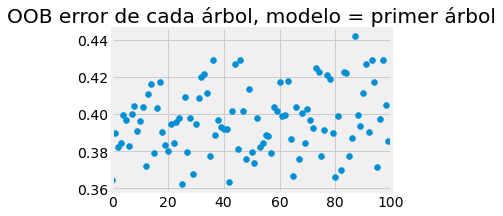

In [133]:
# Visualización de OOB para cada árbol
plt.figure(figsize=(5,3))
plt.style.use('fivethirtyeight')
plt.scatter(range(round(n_estimators/3)), error_DT1)
plt.xlim([0, round(n_estimators/3)])
plt.title('OOB error de cada árbol, modelo = primer árbol')

In [134]:
# Obtención de los pesos alpha
alpha1 = (1 - error_DT1) / (1 - error_DT1).sum()

In [141]:
# Ponderación de las predicciones con los pesos alpha
weighted_sum_DT1 = ((y_pred_DTC1) * alpha1).sum(axis=1)

In [144]:
# Desempeño al hacer votación ponderada
y_pred_error1 = (weighted_sum_DT1 >= 0.5).astype(np.int)


Acc_DTC1_p = metrics.accuracy_score(y_pred_error1, y_test)
F1_DTC1_p = metrics.f1_score(y_pred_error1, y_test)


print('Accuracy árbol 1 ponderado: ', round(Acc_DTC1_p,4))
print('F1 score árbol 1 ponderado: ', round(F1_DTC1_p,4))

Accuracy árbol 1 ponderado:  0.6506
F1 score árbol 1 ponderado:  0.6432


**Árbol 2 - ponderado**

In [145]:
# Estimación de los errores OOB para el modelo 2
error_DT2 = np.zeros(round(n_estimators/3))

for i in range(100,200):
    y_pred_DT2 = modelos[i].predict(X_train.iloc[samples_oob[i]])
    error_DT2[i-100] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_DT2)

Text(0.5, 1.0, 'OOB error de cada árbol, modelo = segundo árbol')

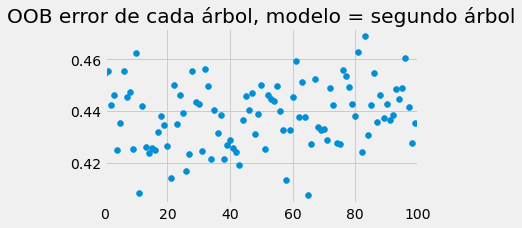

In [146]:
# Visualización de OOB para cada árbol
plt.figure(figsize=(5,3))
plt.style.use('fivethirtyeight')
plt.scatter(range(round(n_estimators/3)), error_DT2)
plt.xlim([0, round(n_estimators/3)])
plt.title('OOB error de cada árbol, modelo = segundo árbol')

In [147]:
# Obtención de los pesos alpha
alpha2 = (1 - error_DT2) / (1 - error_DT2).sum()

In [148]:
# Ponderación de las predicciones con los pesos alpha
weighted_sum_DT2 = ((y_pred_DTC2) * alpha2).sum(axis=1)

In [149]:
# Desempeño al hacer votación ponderada
y_pred_error2 = (weighted_sum_DT2 >= 0.5).astype(np.int)

Acc_DTC2_p = metrics.accuracy_score(y_pred_error2, y_test)
F1_DTC2_p = metrics.f1_score(y_pred_error2, y_test)


print('Accuracy árbol 1 ponderado: ', round(Acc_DTC2_p,4))
print('F1 score árbol 1 ponderado: ', round(F1_DTC2_p,4))

Accuracy árbol 1 ponderado:  0.6433
F1 score árbol 1 ponderado:  0.625


**Reg logística - ponderado**

In [156]:
# Estimación de los errores OOB para el modelo 3
error_RL = np.zeros(round(n_estimators/3))

for i in range(200,300):
    y_pred_RL2 = modelos[i].predict(X_train.iloc[samples_oob[i]])
    error_RL[i-200] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_RL2)

Text(0.5, 1.0, 'OOB error de cada modelo, reg logística')

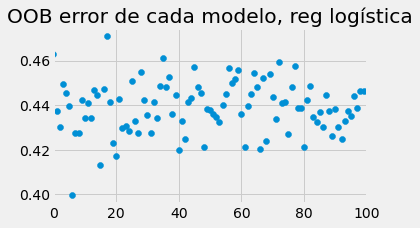

In [162]:
# Visualización de OOB para cada árbol
plt.figure(figsize=(5,3))
plt.style.use('fivethirtyeight')
plt.scatter(range(round(n_estimators/3)), error_RL)
plt.xlim([0, round(n_estimators/3)])
plt.title('OOB error de cada modelo, reg logística')

In [152]:
# Obtención de los pesos alpha 
alpha3 = (1 - error_RL) / (1 - error_RL).sum()

In [158]:
# Ponderación de las predicciones con los pesos alpha
weighted_sum_RL = ((y_pred_RL) * alpha3).sum(axis=1)

In [159]:
# Desempeño al hacer votación ponderada
y_pred_error3 = (weighted_sum_RL >= 0.5).astype(np.int)

Acc_RL_p = metrics.accuracy_score(y_pred_error3, y_test)
F1_RL_p = metrics.f1_score(y_pred_error3, y_test)


print('Accuracy árbol 1 ponderado: ', round(Acc_RL_p,4))
print('F1 score árbol 1 ponderado: ', round(F1_RL_p,4))

Accuracy árbol 1 ponderado:  0.6478
F1 score árbol 1 ponderado:  0.6297


**Ensamble - ponderado**

In [160]:
# Estimación de los errores OOB para cada clasificador
error_pond = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_pond = modelos[i].predict(X_train.iloc[samples_oob[i]])
    error_pond[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_pond)

Text(0.5, 1.0, 'OOB error de cada modelo')

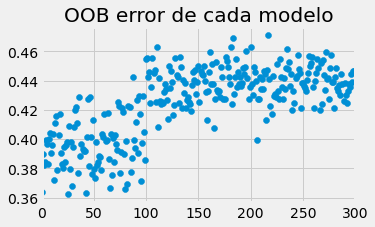

In [163]:
# Visualización de OOB para cada árbol
plt.figure(figsize=(5,3))
plt.style.use('fivethirtyeight')
plt.scatter(range(n_estimators), error_pond)
plt.xlim([0, n_estimators])
plt.title('OOB error de cada modelo')

In [164]:
# Obtención de los pesos alpha de cada modelo 
alpha = (1 - error_pond) / (1 - error_pond).sum()

In [165]:
# Ponderación de las predicciones con los pesos alpha
weighted_sum_pond = ((y_pred_df) * alpha).sum(axis=1)

In [166]:
# Desempeño al hacer votación ponderada
y_pred_error_pond = (weighted_sum_pond >= 0.5).astype(np.int)

Acc_pond = metrics.accuracy_score(y_pred_error_pond, y_test)
F1_pond = metrics.f1_score(y_pred_error_pond, y_test)


print('Accuracy árbol 1 ponderado: ', round(Acc_pond,4))
print('F1 score árbol 1 ponderado: ', round(F1_pond,4))

Accuracy árbol 1 ponderado:  0.6528
F1 score árbol 1 ponderado:  0.6368


#### Análisis punto 8

Se realizan las predicciones con 300 muestras bagged, empleando 3 modelos distintos (cada uno 100 predicciones). 
Al final, se calcularon las métricas de accuracy y F1 score por el método de votación ponderada, para cada modelo y para todo el ensamble:



In [167]:
data_voto2 = [["Árbol 1", round(Acc_DTC1_p,4), round(F1_DTC1_p,4) ], 
        ["Árbol 2", round(Acc_DTC2_p,4), round(F1_DTC2_p,4) ],
        ["Regresión logística", round(Acc_RL_p,4), round(F1_RL_p,4)],
        ["Ensamble2", round(Acc_pond,4), round(Acc_pond,4)]]

resultados_voto2 = pd.DataFrame(data_voto2, columns=["Modelo", "Accuracy", "F1 score"])

resultados_voto2

,Modelo,Accuracy,F1 score
0,Árbol 1,0.6506,0.6432
1,Árbol 2,0.6433,0.6250
2,Regresión logística,0.6478,0.6297
3,Ensamble2,0.6528,0.6528


Se puede observar entonces que el mejor modelo respecto a accuracy y F1 score es el ensamble. 

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

#### Celda 9

Resumiendo, se encontraron los siguientes resultados para accuracy y F1 score en los modelos de ensamble:
    
    Ensamble1	Acc: 0.6533	F1_score: 0.6385
    Ensamble2	Acc: 0.6528	F1_score: 0.6528
    
El desempeño de ambos modelos ensamblados fue mejor que el de cada uno de sus modelos por separado, y en general los dos tuvieron desempeños muy parecidos. 

Estos modelos permiten generar mejores predicciones pero se pierde en parte su interpretabilidad. El modelo con votación ponderada debería dar un mejor resultado, dado que se le asigna mayor peso a las muestras de modelos con menor error, pero en este caso no se ve una diferencia importante respecto al modelo de votación mayoritaria. 
            
            